In [2]:
import pandas as pd
pd.options.display.max_columns = 100

In [3]:
muts_df = pd.read_pickle("./data/GYD_df.pkl")
muts_df.shape

(148, 44)

In [4]:
cond_cnt_d = {"none": 0}
feat_cnt = 0
for _, mut in muts_df.iterrows():
    for feat in mut["genetic features"]:
        feat_cnt += 1
        if len(feat["significantly associated conditions"]) > 0:
            for cond in feat["significantly associated conditions"]:
                if cond in cond_cnt_d.keys():                   
                    cond_cnt_d[cond] += 1
                else:
                    cond_cnt_d[cond] = 1
        else:
            cond_cnt_d["none"] += 1

cond_cnt_d

{'none': 73, 'glycerol(2.5)': 76, 'BOP27': 6}

,condition,mutated feature count,proportion
0,none,73.0,0.470968
1,glycerol(2.5),76.0,0.490323
2,BOP27,6.0,0.038710


Text(0.5, 0, 'mutated feature count')

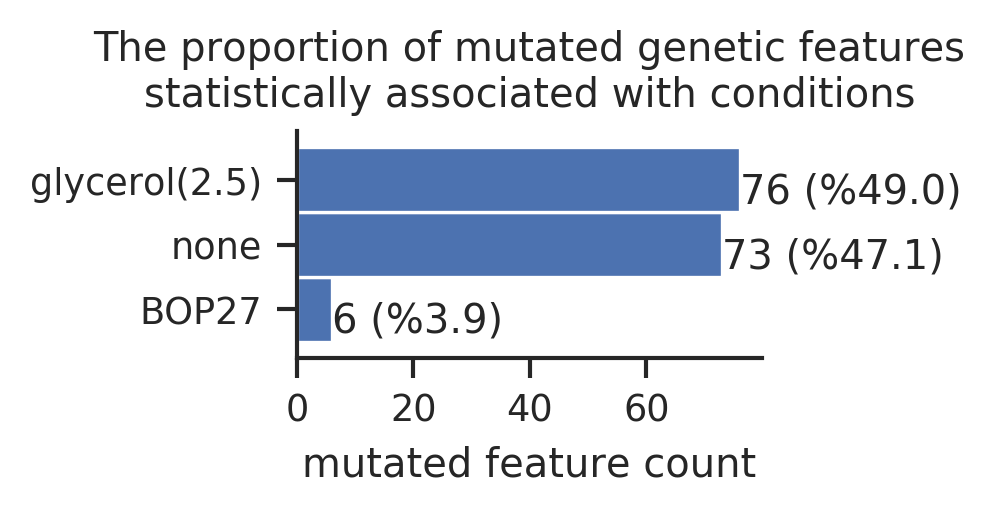

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("ticks")

cond_cnt_df = pd.DataFrame()
for key, val in cond_cnt_d.items():
    cond_cnt_df = cond_cnt_df.append({"condition": key, "mutated feature count": val, "proportion":val/feat_cnt}, ignore_index=True)
display(cond_cnt_df)

cond_cnt_df = cond_cnt_df.sort_values(by="mutated feature count", ascending=True)

ax = cond_cnt_df.plot.barh(
    y="mutated feature count",
    x="condition",
    color="#4C72B0",
    figsize=(2,1),
    width=1
)

cond_cnt_df = cond_cnt_df.reset_index()  # Resetting index for the below annotations to work
for i, r in cond_cnt_df.iterrows(): 
    s = str(int(r["mutated feature count"])) +' (%{0:.1f})'.format(r["proportion"] * 100)
    ax.text(r["mutated feature count"], i-0.35,  s)
sns.despine(ax=ax, top=True, right=True)
ax.set_title("The proportion of mutated genetic features\nstatistically associated with conditions")
ax.get_legend().remove()
sns.despine(ax=ax, top=True, right=True)
ax.set_ylabel('')
ax.set_xlabel("mutated feature count")

In [6]:
import pickle
f = open("./data/signif_genetic_feat_cond_json.pkl", 'rb')   
signif_genomic_feat_cond_json = pickle.load(f)
signif_genomic_feat_cond_json[0:5]

[{'mutated features': 'araA',
  'condition': 'Δpts',
  'odd ratio': 44.3828125,
  'p value': 6.928766063632166e-05},
 {'mutated features': 'b1364',
  'condition': 'Δpgi',
  'odd ratio': 5.680858310626703,
  'p value': 0.00017347421619787488},
 {'mutated features': 'crr',
  'condition': 'glycerol(2.5)',
  'odd ratio': 7.594839293798099,
  'p value': 2.433789127404857e-07},
 {'mutated features': 'csgD/csgB',
  'condition': '42 celsius',
  'odd ratio': 7.113135593220339,
  'p value': 0.003460321263117425},
 {'mutated features': 'cspC',
  'condition': 'glucose(4) or acetate(4)',
  'odd ratio': 21.911082474226806,
  'p value': 0.004769299124647446}]

In [7]:
def get_signif_mut_conds(feat_name):
    signif_mut_conds = []
    for signif_mut_cond in signif_genomic_feat_cond_json:
        if signif_mut_cond['mutated features'] == feat_name:
            signif_mut_conds.append(signif_mut_cond)
    return signif_mut_conds
    
    

cond_mut_feat_assoc_df = pd.DataFrame()
for _, mut in muts_df.iterrows():
    for feat in mut["genetic features"]:
        signif_mut_conds = get_signif_mut_conds(feat["name"])
        for d in signif_mut_conds:
            cond_mut_feat_assoc_df = cond_mut_feat_assoc_df.append(d, ignore_index=True)

cond_mut_feat_assoc_df = cond_mut_feat_assoc_df.rename(columns={"mutated features": "mutated genetic features"})
cond_mut_feat_assoc_df.head()

,condition,mutated genetic features,odd ratio,p value
0,glycerol(2.5),cyaA,9.612060,2.129720e-13
1,glycerol(2.5),glpK,11.196365,4.666593e-21
2,BOP27,hns/tdk,1.584046,7.673960e-03
3,U-13C glucose(2),hns/tdk,7.471429,2.905791e-04
4,glycerol(2.5),crr,7.594839,2.433789e-07


In [8]:
gyd_cond_mut_feat_assoc_df = cond_mut_feat_assoc_df[cond_mut_feat_assoc_df["condition"].isin(cond_cnt_d.keys())].copy()

cross_counts_df = pd.crosstab(
    gyd_cond_mut_feat_assoc_df["mutated genetic features"],
    gyd_cond_mut_feat_assoc_df["condition"]
)

cross_counts_df

condition,BOP27,glycerol(2.5)
mutated genetic features,,
crr,0,10
cyaA,0,21
glpK,0,28
hisL/hisG,0,6
hns/tdk,6,0
leuA/leuL,0,3
opgH/yceK,0,2
pgrR/mppA,0,1
rpsM,0,1


In [9]:
bin_df = cross_counts_df.copy()
for ir, r in bin_df.iterrows():
    for ic, c in r.items():
        if bin_df.loc[ir, ic] > 0:
            bin_df.loc[ir, ic] = 1
display(bin_df)

condition,BOP27,glycerol(2.5)
mutated genetic features,,
crr,0,1
cyaA,0,1
glpK,0,1
hisL/hisG,0,1
hns/tdk,1,0
leuA/leuL,0,1
opgH/yceK,0,1
pgrR/mppA,0,1
rpsM,0,1


Text(0.5, 81.49999999999984, '')

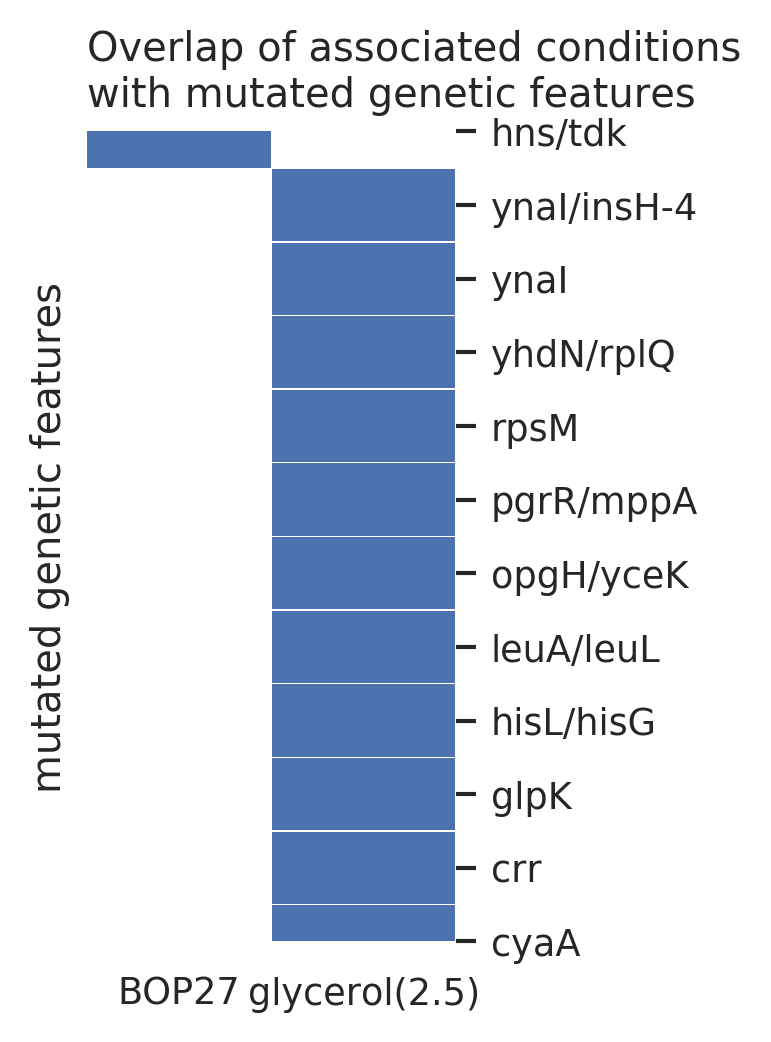

In [10]:
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("whitegrid")

from matplotlib.colors import LinearSegmentedColormap
myColors = ('#FFFFFF', "#4C72B0")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

g = sns.clustermap(
    bin_df,
    linewidths=0.1,
    cmap=cmap,
#     xticklabels=False,
#     yticklabels=False,
    figsize=(2,4.5)
)
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
ax = g.ax_heatmap
g.ax_heatmap.set_title(
    "Overlap of associated conditions\nwith mutated genetic features",
    loc='left'
)
# ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position("left")
ax.set_xlabel('')
# plt.title()

In [11]:
cond_mut_feat_assoc_df.head()

,condition,mutated genetic features,odd ratio,p value
0,glycerol(2.5),cyaA,9.612060,2.129720e-13
1,glycerol(2.5),glpK,11.196365,4.666593e-21
2,BOP27,hns/tdk,1.584046,7.673960e-03
3,U-13C glucose(2),hns/tdk,7.471429,2.905791e-04
4,glycerol(2.5),crr,7.594839,2.433789e-07


In [13]:
# only want to plot genetic targets that have significant convergences
# I only want to look at mutated targets that have significant convergence
signif_gen_targ_s = set()
for _, r in muts_df.iterrows():
    for f in r["genetic features"]:
        if f["significant"]:
            signif_gen_targ_s.add(f["name"])
signif_gen_targ_s

{'crr',
 'cyaA',
 'flhD',
 'glpK',
 'glxK/allE',
 'hisL/hisG',
 'hns/tdk',
 'leuA/leuL',
 'mstA/C0614',
 'opgH/yceK',
 'pgrR/mppA',
 'rbfA/infB',
 'rpoB',
 'rpsM',
 'yhdN/rplQ',
 'ynaI',
 'ynaI/insH-4'}

In [17]:
odds_df = bin_df.copy()
for feat, r in bin_df.iterrows():
    for cond, c in r.items():
        if bin_df.loc[feat, cond] > 0:
            odd_ratio = 0
            df = cond_mut_feat_assoc_df[
                (cond_mut_feat_assoc_df["condition"]==cond)
                & (cond_mut_feat_assoc_df["mutated genetic features"]==feat)]["odd ratio"]
            if len(df):
                odd_ratio = df.unique()
            odds_df.loc[feat, cond] = odd_ratio
            
odds_df = odds_df[odds_df.index.isin(signif_gen_targ_s)]
# odds_df.index = '*'+odds_df.index
odds_df

condition,BOP27,glycerol(2.5)
mutated genetic features,,
crr,0.000000,7.594839
cyaA,0.000000,9.612060
glpK,0.000000,11.196365
hisL/hisG,0.000000,9.408735
hns/tdk,1.584046,0.000000
leuA/leuL,0.000000,10.719543
opgH/yceK,0.000000,10.769133
pgrR/mppA,0.000000,10.819231
rpsM,0.000000,10.819231


In [36]:
# \textit{line 2}
odds_df = odds_df.rename(columns=
                         {'511145': "E. coli K12 MG1655 strain",
                          "BOP27": "starting strain mutations",
                          "glycerol(2.5)": "glycerol as a carbon source",
                          "M9": "M9 minimal media"
                         }
                        )
odds_df

condition,starting strain mutations,glycerol as a carbon source
mutated genetic features,,
crr,0.000000,7.594839
cyaA,0.000000,9.612060
glpK,0.000000,11.196365
hisL/hisG,0.000000,9.408735
hns/tdk,1.584046,0.000000
leuA/leuL,0.000000,10.719543
opgH/yceK,0.000000,10.769133
pgrR/mppA,0.000000,10.819231
rpsM,0.000000,10.819231


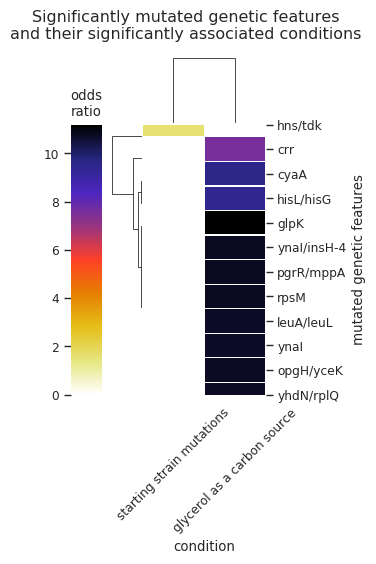

In [37]:
plt.rcParams["figure.dpi"] = 100
sns.set_context("paper")
sns.set_style("white")

g = sns.clustermap(
    odds_df,
    linewidths=0.1,
    cmap="CMRmap_r",
#     xticklabels=False,
#     yticklabels=False,
    figsize=(2,4.5)
#     figsize=(4,2)
)
# g.cax.set_visible(False)
# g.ax_row_dendrogram.set_visible(False)
# g.ax_col_dendrogram.set_visible(False)
g.fig.suptitle("Significantly mutated genetic features\nand their significantly associated conditions")
g.cax.set_title("odds\nratio")
g.cax.yaxis.set_ticks_position("left")
# g.ax_heatmap.set_title(
#     "Overlap of associated conditions\nwith mutated genetic features",
# #     loc='top'
# )
# ax.yaxis.set_ticks_position('left')
# ax.yaxis.set_label_position("left")
dendro_box = g.ax_row_dendrogram.get_position()
dendro_box.x0-=0.2
dendro_box.x1-=0.2
g.cax.set_position(dendro_box)
# g.clustermap.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
# set_xticklabels(rotation=30)
# g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45)
plt.savefig("fig.svg", format="svg")

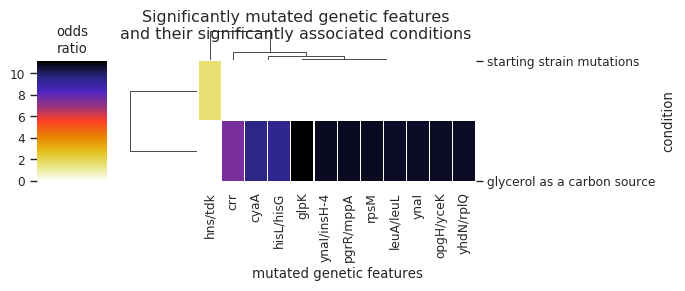

In [38]:
plt.rcParams["figure.dpi"] = 100
sns.set_context("paper")
sns.set_style("white")

g = sns.clustermap(
    odds_df.T,
    linewidths=0.1,
    cmap="CMRmap_r",
#     xticklabels=False,
#     yticklabels=False,
    figsize=(4.5,2)
#     figsize=(4,2)
)
# g.cax.set_visible(False)
# g.ax_row_dendrogram.set_visible(False)
# g.ax_col_dendrogram.set_visible(False)
g.fig.suptitle("Significantly mutated genetic features\nand their significantly associated conditions")
g.cax.set_title("odds\nratio")
g.cax.yaxis.set_ticks_position("left")
# g.ax_heatmap.set_title(
#     "Overlap of associated conditions\nwith mutated genetic features",
# #     loc='top'
# )
# ax.yaxis.set_ticks_position('left')
# ax.yaxis.set_label_position("left")
dendro_box = g.ax_row_dendrogram.get_position()
dendro_box.x0-=0.2
dendro_box.x1-=0.2
g.cax.set_position(dendro_box)
# g.clustermap.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
# set_xticklabels(rotation=30)
# g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45)
plt.savefig("fig.svg", format="svg")

In [39]:
KEY_MUT_FEATS = ["glpK", "cyaA", "crr"]
display(
    len(KEY_MUT_FEATS),
    len(set(KEY_MUT_FEATS) & set(cond_mut_feat_assoc_df['mutated genetic features'])),
    set(KEY_MUT_FEATS) - set(cond_mut_feat_assoc_df['mutated genetic features'])
)

3

3

set()

In [40]:
key_mut_feat_df = cond_mut_feat_assoc_df[
    cond_mut_feat_assoc_df["mutated genetic features"].isin(KEY_MUT_FEATS)
    & cond_mut_feat_assoc_df["condition"].isin(cond_cnt_d.keys())  # only considering conditions to local experiment
]
key_mut_feat_df = key_mut_feat_df.drop_duplicates()
key_mut_feat_df

,condition,mutated genetic features,odd ratio,p value
0,glycerol(2.5),cyaA,9.612060,2.129720e-13
1,glycerol(2.5),glpK,11.196365,4.666593e-21
4,glycerol(2.5),crr,7.594839,2.433789e-07


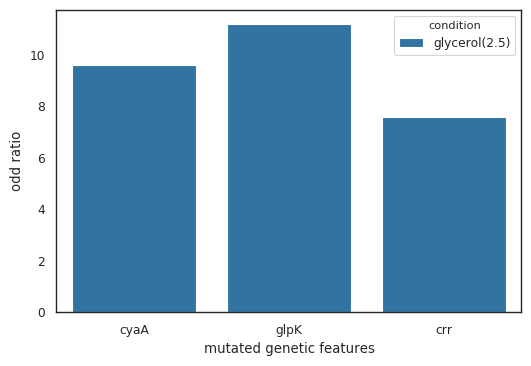

In [41]:
ax = sns.barplot(data=key_mut_feat_df ,x="mutated genetic features", y="odd ratio", hue="condition")

In [42]:
gly_key_mut_feat_df = key_mut_feat_df[key_mut_feat_df.condition=="glycerol(2.5)"]
gly_key_mut_feat_df

,condition,mutated genetic features,odd ratio,p value
0,glycerol(2.5),cyaA,9.612060,2.129720e-13
1,glycerol(2.5),glpK,11.196365,4.666593e-21
4,glycerol(2.5),crr,7.594839,2.433789e-07


In [43]:
# for some reason I have to do this up here and not in the below plotting cell.
gly_key_mut_feat_df = gly_key_mut_feat_df.sort_values("odd ratio")
gly_key_mut_feat_df

,condition,mutated genetic features,odd ratio,p value
4,glycerol(2.5),crr,7.594839,2.433789e-07
0,glycerol(2.5),cyaA,9.612060,2.129720e-13
1,glycerol(2.5),glpK,11.196365,4.666593e-21


In [44]:
gly_key_mut_feat_df["mutated genetic features"] = gly_key_mut_feat_df["mutated genetic features"].apply(lambda x: '$\it{' + x + '}$')
gly_key_mut_feat_df

,condition,mutated genetic features,odd ratio,p value
4,glycerol(2.5),$\it{crr}$,7.594839,2.433789e-07
0,glycerol(2.5),$\it{cyaA}$,9.612060,2.129720e-13
1,glycerol(2.5),$\it{glpK}$,11.196365,4.666593e-21


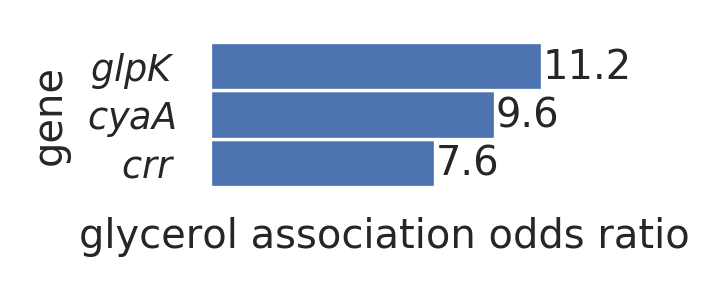

In [45]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("white")


ax = gly_key_mut_feat_df.plot.barh(
    y="odd ratio",
    x="mutated genetic features",
    color="#4C72B0",
    figsize=(1.5,0.75),
    width=1
)

gly_key_mut_feat_df = gly_key_mut_feat_df.reset_index()  # Resetting index for the below annotations to work
for i, r in gly_key_mut_feat_df.iterrows():
    s = str(round(r["odd ratio"], 1))
#     s = int(r["odd ratio"])
#     ax.text(r["odd ratio"], i-0.25,  s)    
#     s = ""
#     if r["p value"] < 0.01: s = "p<0.01"
#     else: s = "p=" + '{0:.3f}'.format(r["p value"])
    ax.text(r["odd ratio"], i-0.25,  s)
sns.despine(ax=ax,
            top=True,
            right=True, 
            bottom=True,
            left=True
           )
# ax.set_title("mutated genetic features\nassociated with L-serine and\nΔsdaA ΔsdaB ΔtdcG ΔglyA")
# ax.set_title("mutated genetic features\nassociated with glycerol")
# ax.set_title("Key mutation features\nassociated with glycerol")
# ax.set_title("Glycerol association for\nfrequently mutated genetic features")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.get_legend().remove()
ax.set_ylabel('gene')
# ax.set_ylabel('$\it{glpK}$\n domain')
ax.set_xlabel("glycerol association odds ratio")
plt.savefig("fig.svg", format="svg")

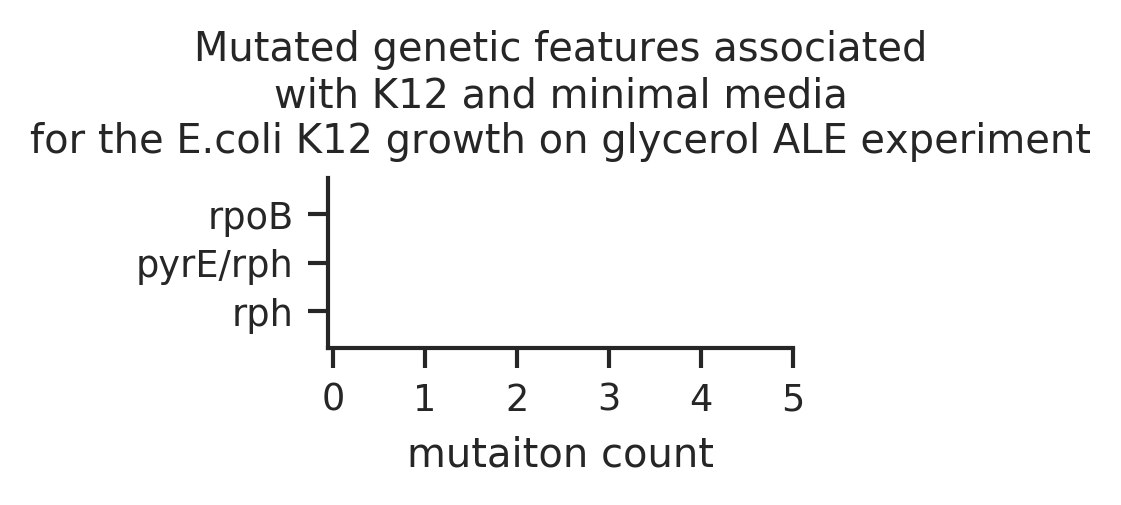

In [46]:
# want a histogram of the amount of times genetic targets associated with {"511145", "M9"} are mutated
gen_feat_cnt_d = {}
for _, m in muts_df.iterrows():
    for g in m["genetic features"]:
        if g["significantly associated conditions"] == set(["511145", "M9"]):
#             display(m)
            if g["name"] in gen_feat_cnt_d.keys():
                gen_feat_cnt_d[g["name"]] += 1
            else:
                gen_feat_cnt_d[g["name"]] = 1
                
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("ticks")
df = pd.DataFrame.from_dict(gen_feat_cnt_d, orient='index', columns=["mutation count"])

# Manual sorting
df = df.reindex(["rph", "pyrE/rph", "rpoB"])

ax = df.plot.barh(
    y="mutation count",
#     x="index",
    color="#4C72B0",
    figsize=(2,0.75),
    width=1
)
ax.set_title("Mutated genetic features associated\nwith K12 and minimal media\nfor the E.coli K12 growth on glycerol ALE experiment")
ax.get_legend().remove()
ax.set_ylabel('')
ax.set_xlabel("mutaiton count")
sns.despine(ax=ax, top=True, right=True, 
#             bottom=True,
#             left=True
           )
import numpy as np
ax.xaxis.set_ticks(np.arange(0, 6, 1))